In [1]:
#import necessary modules

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
from sklearn.svm import LinearSVC
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

/home/qhan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/qhan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#plot helper function
def plot_comparision_images(original, trans, title1='Original', title2='Processed', cmap1=None, cmap2=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
    f.tight_layout()
    ax1.imshow(original, cmap=cmap1)
    ax1.set_title(title1, fontsize=15)
    ax2.imshow(trans, cmap=cmap2)
    ax2.set_title(title2, fontsize=15)

## Read images

In [3]:
def readImages(directory):
    images = []
    image_names = glob.glob(directory + '/*/*.png')
    for image_name in image_names:
        bgr = cv2.imread(image_name)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        images.append(rgb)
    return images

vehicle_images = readImages('./vehicles') 
non_vehicle_images = readImages('./non-vehicles') 
print('Total vehicle images are %d:'%len(vehicle_images))
print('Total non-vehicle images are %d:'%len(non_vehicle_images))

Total vehicle images are 8792:
Total non-vehicle images are 8968:


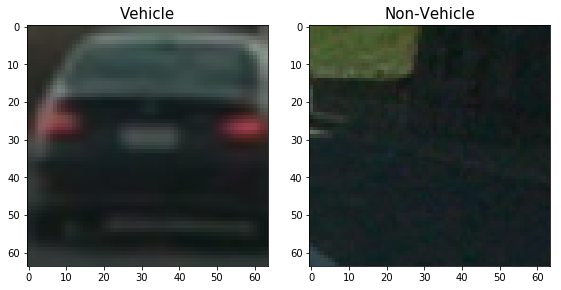

In [5]:
#show example images
plot_comparision_images(vehicle_images[1], non_vehicle_images[1], title1='Vehicle', title2='Non-Vehicle')

## Build classifier

### 1. Feature extration

In [10]:
#encapsulate all tunable params in an object
class FeaturePrams():
    def __init__(self):
        self.color_space = 'YCrCb'
        self.spatial_size = (32, 32)
        self.hist_bins = 32
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        self.hist_range = (0, 256)
        self.spatial_feat = True
        self.hist_feat = True
        self.hog_feat = True

g_params = FeaturePrams()

# util functions copyied from lectures/quiz
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [11]:
def single_img_features(img, params):    
    
    color_space = params.color_space
    spatial_size = params.spatial_size
    hist_bins = params.hist_bins
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    spatial_feat = params.spatial_feat
    hist_feat = params.hist_feat
    hog_feat = params.hog_feat
    
    #1) Define an empty list to receive features
    
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, params):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        image_features = single_img_features(img, params)
        features.append(image_features)
    # Return list of feature vectors
    return features

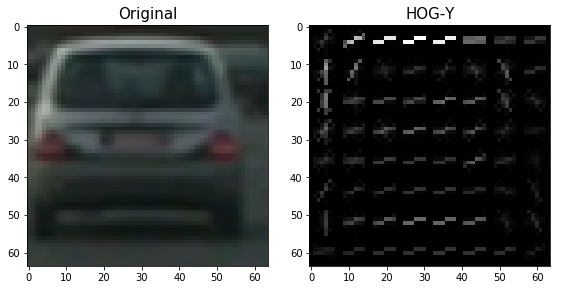

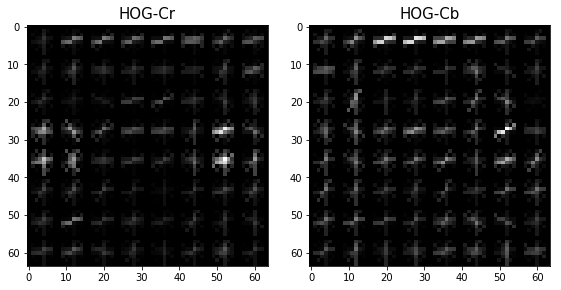

In [35]:
#test hog feature
test_image = vehicle_images[3]
ycc = cv2.cvtColor(test_image, cv2.COLOR_RGB2YCrCb)
_, hog_image = get_hog_features(ycc[:, :, 0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

plot_comparision_images(test_image, hog_image, title1='Original', title2='HOG-Y', cmap2='gray')

_, hog_image1 = get_hog_features(ycc[:, :, 1], orient=9, pix_per_cell=8, cell_per_block=2,
                                vis=True, feature_vec=True)
_, hog_image2 = get_hog_features(ycc[:, :, 2], orient=9, pix_per_cell=8, cell_per_block=2,
                                vis=True, feature_vec=True)
plot_comparision_images(hog_image1, hog_image2, title1='HOG-Cr', cmap1='gray', title2='HOG-Cb', cmap2='gray')

### 2. Model training

In [12]:
car_features = extract_features(vehicle_images, g_params)
notcar_features = extract_features(non_vehicle_images, g_params)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


/home/qhan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [13]:
print('Using spatial binning of:', g_params.spatial_size,
    'and', g_params.hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 30
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 8460
15.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9924
My SVC predicts:  [1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 1. 0. 1. 1. 0.]
For these 30 labels:  [1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 1. 0. 1. 1. 0.]
0.00205 Seconds to predict 30 labels with SVC


### 3. Save model

In [7]:
#save svc related params
import pickle
svc_dict = {}
svc_dict['params'] = g_params
svc_dict['svc'] = svc
svc_dict['scaler'] = X_scaler

with open('svc_pickle.p','wb') as f:
    pickle.dump(svc_dict, f)
f.close()

NameError: name 'g_params' is not defined

In [13]:
# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
params = dist_pickle["params"]


## Sliding window

In [14]:
# Util functions provided by udacity

def draw_boxes(img, bboxes, color=(0, 255, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [15]:
def search_windows(img, clf, scaler, params, y_start_stop=[350, 700], xy_window=(64, 64), xy_overlap=(0.8, 0.8)):
    """
    Returns the windows where the cars are found on the image `img`.
    The feature extraction used parameters `params`.
    `y_start_stop` : Contains the Y axis range to find the cars.
    `xy_window` : Contains the windows size.
    `xy_overlap` : Contains the windows overlap percent.
    Returns a new image with the cars windows.
    """
    positive_windows = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = single_img_features(test_img, params)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = clf.predict(scaled_features)
        if pred == 1:
            positive_windows.append(window)
    return positive_windows


/home/qhan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


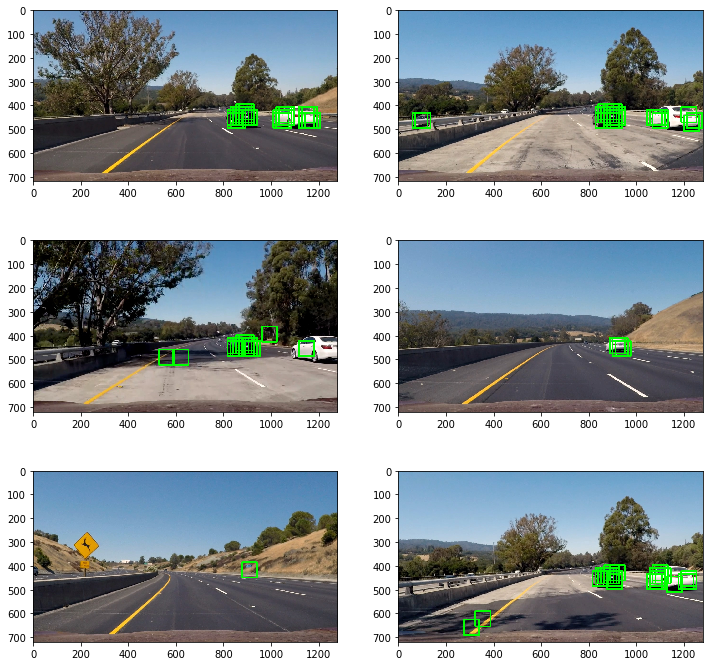

In [16]:
#read all test images
test_images = list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB),
                       glob.glob('./test_images/*.jpg')))

test_output = list(map(lambda img: draw_boxes(img, search_windows(img, svc, X_scaler, g_params)), test_images))

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
indexes = range(6)
for ax, index in zip(axes.flat, indexes):
    if index < 6:
        img = test_output[index]
        ax.imshow(img)

# Improvements

### 1. Hog Sub-sampling Window Search

In [17]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, params, ystart=350, ystop=700, scale=1.5):
    #unpack params
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    spatial_size = params.spatial_size
    hist_bins = params.hist_bins
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255 scaling is not needed here as image is readin by cv2.imread
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    out_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                out_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return out_windows

/home/qhan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


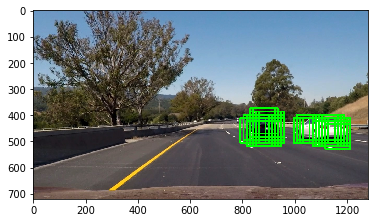

In [18]:
#test 1
test_image = test_images[0]
out_windows = find_cars(test_image, svc, X_scaler, g_params)
plt.imshow(draw_boxes(test_image, out_windows))


/home/qhan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


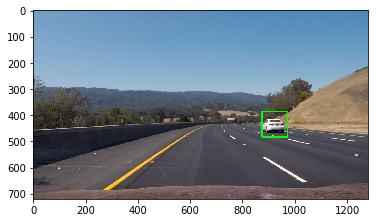

In [19]:
#test 2
test_image = test_images[3]
out_windows = find_cars(test_image, svc, X_scaler, g_params)
plt.imshow(draw_boxes(test_image, out_windows))

### Heat map

In [20]:
#Util functions provided by Udacity
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

/home/qhan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


2 cars found


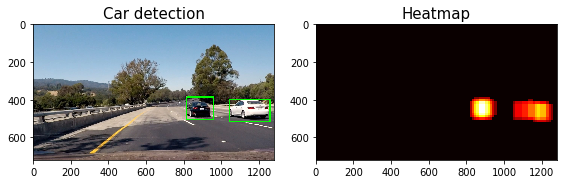

In [22]:
test_image = test_images[5]
bbox_list = find_cars(test_image, svc, X_scaler, params)
heatmap = np.zeros_like(test_image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, bbox_list)
heatmap = apply_threshold(heatmap, threshold=2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heatmap, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

print(labels[1], 'cars found')
plot_comparision_images(draw_img, heatmap, title1='Car detection', title2='Heatmap', cmap2='hot')



/home/qhan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1 cars found


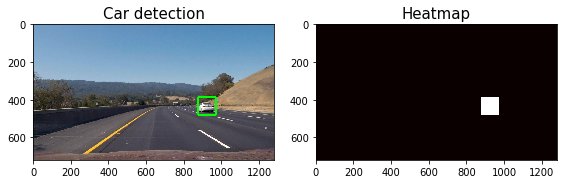

In [25]:
test_image = test_images[3]
bbox_list = find_cars(test_image, svc, X_scaler, params)
heatmap = np.zeros_like(test_image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, bbox_list)
heatmap = apply_threshold(heatmap, threshold=0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heatmap, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

print(labels[1], 'cars found')
plot_comparision_images(draw_img, heatmap, title1='Car detection', title2='Heatmap', cmap2='hot')

# Video pipeline

In [30]:
from moviepy.editor import VideoFileClip
from functools import reduce

frames_to_keep = 3
threshhold = 2

class HeatHistory():
    def __init__(self):
        self.history = []
hh = HeatHistory()
        
def pipeline(img):
    windows = find_cars(img, svc, X_scaler, g_params)
    img_shape = img.shape
    heatmap = add_heat(np.zeros(img_shape), windows)
    if len(hh.history) >= frames_to_keep:
        hh.history = hh.history[1:]

    hh.history.append(heatmap)
    heat_history = reduce(lambda h, acc: h + acc, hh.history) / frames_to_keep
    heatmap = apply_threshold(heat_history, threshhold)
    labels = label(heatmap)

    return draw_labeled_bboxes(np.copy(img), labels)      


myclip = VideoFileClip('./project_video.mp4')
output_video = myclip.fl_image(pipeline)
output_video.write_videofile('./project_video_out.mp4', audio=False)
    

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████▉| 1260/1261 [28:28<00:01,  1.36s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

